In [79]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.stats import binned_statistic_dd, truncnorm
import pandas as pd
from collections import Counter
from itertools import product
import os
import sys
sys.path.append("../data_extraction/")
from utils import flatten_logic

In [2]:
FEATURE_COLUMNS = ['Valence', 'Arousal', 'Dominance', 'Politeness', 'Formality']

In [3]:
def get_bins(data, num_bins):
    """Return the bin index that each data point in data falls into, given the space
    is subdivided to have num_bins equally sized bins.

    A bin number of i means that the corresponding value is between bin_edges[i-1], bin_edges[i]

    Returns both the bin index as a unique integer, as well as in terms of a 5d
    array corresponding to each dimension.
    """
    # Initialize uniformly-sized bins
    bin_edges = np.linspace(0, 1, (num_bins + 1))

    # We need to know where in the space each bin id maps to, so edges are necessary

    # TO DO: Can we modify the statistic to directly calculate a vector valued statistic?
    stats, edges, binnumber = binned_statistic_dd(data, np.arange(len(data)),
                                                  statistic="mean",
                                                  bins=[bin_edges for i in range(data.shape[1])])
    
    stats, edges, unraveled_binnumber = binned_statistic_dd(data, np.arange(len(data)),
                                                            statistic="mean",
                                                            bins=[bin_edges for i in range(data.shape[1])],
                                                            expand_binnumbers=True)

    # Return the bin IDs
    return binnumber, unraveled_binnumber.transpose()

In [38]:
ROOT_DIR = "/ais/hal9000/datasets/reddit/jai_stance_embeddings/unmasked/"
files = sorted(os.listdir(ROOT_DIR))
dfs = []
for file in files:
    df = pd.read_csv(ROOT_DIR + file)
    dfs.append(df)
df = pd.concat(dfs)
del dfs
df = df.set_index("id")
df['rel_marker'] = df['rel_marker'].apply(lambda x: eval(x)[0])
df['Politeness'] = (df["Politeness"] - df['Politeness'].min())/(df['Politeness'].max() - df['Politeness'].min())

In [41]:
bins, ubins = get_bins(df[FEATURE_COLUMNS].to_numpy(), 2)

In [42]:
def get_bin_names(arr):
    features = list("VADPF")
    names = []
    for row in arr:
        name = "".join(flatten_logic(list(zip(features, row.astype(str)))))
        names.append(name)
    return names
    
df['bin'] = get_bin_names(ubins)

In [146]:
ROOT_DIR

'/ais/hal9000/datasets/reddit/jai_stance_embeddings/unmasked/'

In [149]:
x = df.groupby("bin")[FEATURE_COLUMNS].mean()

In [150]:
x.to_csv(ROOT_DIR + "output/original_space_data.csv")

In [50]:
all_markers = sorted(df['rel_marker'].unique())

In [51]:
agg = df.groupby(["subreddit", "bin", "rel_marker"]).count()

In [67]:
df['sub_marker'] = df["subreddit"] + "_" + df['rel_marker']

In [69]:
agg = df.groupby(["bin", "sub_marker"]).count()

In [85]:
comms = df['subreddit'].unique()
markers = df['rel_marker'].unique()
bins = df['bin'].unique()
com_markers = list(product(comms, markers))
com_markers = ["_".join(pair) for pair in com_markers]
len(com_markers)

5625

In [92]:
full_counts = pd.DataFrame(0, index=pd.MultiIndex.from_product([bins, com_markers], names=["bin", "sub_marker"]), columns=agg.columns)

In [95]:
total = agg.add(full_counts, fill_value=0)

In [106]:
total = total.reset_index()

In [164]:
cooc_matrix = pd.crosstab(total['bin'], total['sub_marker'], total['body'], aggfunc="sum")

In [165]:
cooc_matrix_np = cooc_matrix.to_numpy()
print(cooc_matrix.shape)
P, D, Q = np.linalg.svd(cooc_matrix_np, full_matrices=False)

(32, 5625)


In [166]:
var_explained = np.round(D**2/np.sum(D**2), decimals=3)
var_explained


array([0.877, 0.045, 0.034, 0.024, 0.01 , 0.003, 0.002, 0.001, 0.001,
       0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   ])

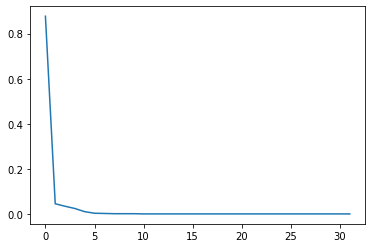

In [167]:
plt.plot(np.arange(len(var_explained)), var_explained)

In [168]:
cooc_matrix.index

Index(['V1A1D1P1F1', 'V1A1D1P1F2', 'V1A1D1P2F1', 'V1A1D1P2F2', 'V1A1D2P1F1',
       'V1A1D2P1F2', 'V1A1D2P2F1', 'V1A1D2P2F2', 'V1A2D1P1F1', 'V1A2D1P1F2',
       'V1A2D1P2F1', 'V1A2D1P2F2', 'V1A2D2P1F1', 'V1A2D2P1F2', 'V1A2D2P2F1',
       'V1A2D2P2F2', 'V2A1D1P1F1', 'V2A1D1P1F2', 'V2A1D1P2F1', 'V2A1D1P2F2',
       'V2A1D2P1F1', 'V2A1D2P1F2', 'V2A1D2P2F1', 'V2A1D2P2F2', 'V2A2D1P1F1',
       'V2A2D1P1F2', 'V2A2D1P2F1', 'V2A2D1P2F2', 'V2A2D2P1F1', 'V2A2D2P1F2',
       'V2A2D2P2F1', 'V2A2D2P2F2'],
      dtype='object', name='bin')

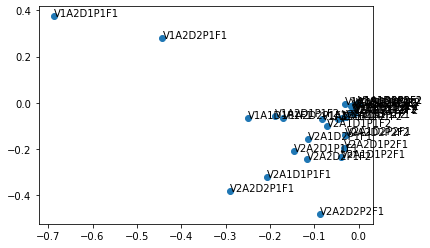

In [174]:
plt.scatter(P[:, 0], P[:, 1])
for x, y, label in zip(P[:, 0], P[:, 1], cooc_matrix.index):
    plt.text(x, y, label)